In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math as math
from plotnine import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/senatepolls/senate_polls.csv


# Step 1: Download Polling Data

In [2]:
df = pd.read_csv("/kaggle/input/senatepolls/senate_polls.csv")

In [3]:
df

,poll_id,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,numeric_grade,pollscore,...,stage,nationwide_batch,ranked_choice_reallocated,ranked_choice_round,hypothetical,party,answer,candidate_id,candidate_name,pct
0,88606,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,DEM,Gallego,30920,Ruben Gallego,50.0
1,88606,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,REP,Lake,30921,Kari Lake,43.4
2,88608,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,DEM,Slotkin,31025,Elissa Slotkin,48.7
3,88608,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,REP,Rogers,31045,Mike Rogers,43.5
4,88609,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,DEM,Rosen,31010,Jacky S. Rosen,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,78370,1008,Triton Polling & Research,1467,WMOV Radio,Triton Polling & Research,497,Triton Polling & Research,NaN,0.8,...,general,False,False,NaN,True,REP,Mooney,28806,Alexander X. Mooney,27.7
1791,78370,1008,Triton Polling & Research,1467,WMOV Radio,Triton Polling & Research,497,Triton Polling & Research,NaN,0.8,...,general,False,False,NaN,True,DEM,Manchin,28805,"Joe Manchin, III",49.9
1792,78370,1008,Triton Polling & Research,1467,WMOV Radio,Triton Polling & Research,497,Triton Polling & Research,NaN,0.8,...,general,False,False,NaN,True,REP,Morrisey,28807,Patrick Morrisey,28.6
1793,78370,1008,Triton Polling & Research,1467,WMOV Radio,Triton Polling & Research,497,Triton Polling & Research,NaN,0.8,...,general,False,False,NaN,True,DEM,Manchin,28805,"Joe Manchin, III",41.0


# Step 2: Preparing the Data

Arizona (Ruben Gallego (D) vs. Kari Lake (R))

Nevada (JACKY ROSEN (D) vs. Sam Brown (R))

Pennsylvania (BOB CASEY JR. (D) vs. Dave McCormick (R))

Michigan (Elissa Slotkin (D) vs. Mike Rogers (R))

Ohio (SHERROD BROWN (D) vs. Bernie Moreno (R))

Wisconsin (TAMMY BALDWIN (D) vs. Eric Hovde (R))

Montana (JOHN TESTER (D) vs. Tim Sheehy (R))

Texas (Colin Allred (D) vs. TED CRUZ (R))

In [4]:
# Format the created_at column of the polling DataFrame as a datetime and then select 
#only the poll with the latest value for each state. If there are multiple polls entered 
#on the same date, select the one with the larger sample_size

#https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
df["created_at"] = pd.to_datetime(df["created_at"])

df["created_at"] 

/tmp/ipykernel_17/2232884713.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


0      2024-10-10 09:02:00
1      2024-10-10 09:02:00
2      2024-10-10 09:02:00
3      2024-10-10 09:02:00
4      2024-10-10 09:02:00
               ...        
1790   2022-02-01 10:28:00
1791   2022-02-01 10:28:00
1792   2022-02-01 10:28:00
1793   2022-02-01 10:28:00
1794   2022-02-01 10:28:00
Name: created_at, Length: 1795, dtype: datetime64[ns]

In [5]:
#if there are multiple polls on the same date, then pull the date with largest sample size

#sort by values of each state by createdat and sample_size, then drop duplicates
clean = df.sort_values(by=["state", "created_at", "sample_size"], ascending=[True, False, False])

clean = clean.drop_duplicates(subset=["state"], keep="first")

clean

,poll_id,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,numeric_grade,pollscore,...,stage,nationwide_batch,ranked_choice_reallocated,ranked_choice_round,hypothetical,party,answer,candidate_id,candidate_name,pct
0,88606,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,DEM,Gallego,30920,Ruben Gallego,50.0
224,88422,1852,USC Dornsife/CSU Long Beach/Cal Poly Pomona,NaN,NaN,University of Southern California/California S...,830,USC Dornsife/CSU Long Beach/Cal Poly Pomona,NaN,NaN,...,general,False,False,NaN,False,DEM,Schiff,30942,Adam B. Schiff,56.4
379,88298,290,MassINC Polling Group,2199,CT Mirror,MassINC Polling Group,198,MassINC Polling Group,2.8,-0.8,...,general,False,False,NaN,False,DEM,Murphy,37084,Christopher S. Murphy,51.0
342,88409,499,University of Delaware,NaN,NaN,University of Delaware Center for Political Co...,433,University of Delaware Center for Political Co...,NaN,NaN,...,general,False,False,NaN,False,DEM,Blunt Rochester,31366,Lisa Blunt Rochester,52.1
50,88555,1424,Siena/NYT,NaN,NaN,The New York Times/Siena College,448,The New York Times/Siena College,3.0,-1.5,...,general,False,False,NaN,False,DEM,Mucarsel-Powell,31615,Debbie Mucarsel-Powell,39.0
56,88519,1741,ActiVote,NaN,NaN,ActiVote,721,ActiVote,NaN,NaN,...,general,False,False,NaN,False,DEM,McCray,31088,Valerie McCray,43.9
447,88220,365,Pan Atlantic Research,NaN,NaN,Pan Atlantic Research,249,Pan Atlantic Research,2.1,-0.1,...,general,False,False,NaN,False,DEM,Costello,36287,David Allen Costello,8.0
148,88586,1899,UMBC,NaN,NaN,University of Maryland Baltimore County Instit...,869,UMBC Institute of Politics,NaN,NaN,...,general,False,False,NaN,False,DEM,Alsobrooks,31370,Angela Alsobrooks,48.0
54,88551,458,Suffolk,68,Boston Globe,Suffolk University,323,Suffolk University,2.9,-1.0,...,general,False,False,NaN,False,DEM,Warren,31002,Elizabeth Ann Warren,58.6
2,88608,1102,Emerson,1185,Nexstar,Emerson College,88,Emerson College,2.9,-1.1,...,general,False,False,NaN,False,DEM,Slotkin,31025,Elissa Slotkin,48.7


In [6]:
# we will need the data in the sample_size, party, and pct columns. The sample_size is how 
# many people were surveyed in this poll, the party lists the choice offered (Note: answer 
# is actually the choice offered, but since we are rolling this up to political parties 
# it makes sense to work with the party column), and the pct is the percent of people who 
# selected this choice. Divide the value in pct by 100, so it is a number between 0 and 1
df_new = clean[["state", "sample_size", "party", "pct"]]
df_new["pct"] = df_new["pct"]/100
df_new = df_new[df_new["party"] == "DEM"]
df_new = df_new[(df_new["state"] == "Arizona") | (df_new["state"] == "Nevada") |
               (df_new["state"] == "Pennsylvania") | (df_new["state"] == "Michigan") |
               (df_new["state"] == "Ohio") | (df_new["state"] == "Wisconsin") |
               (df_new["state"] == "Montana") | (df_new["state"] == "Texas")]
df_new

/tmp/ipykernel_17/357335841.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,state,sample_size,party,pct
0,Arizona,1000.0,DEM,0.500
2,Michigan,950.0,DEM,0.487
10,Montana,656.0,DEM,0.440
4,Nevada,900.0,DEM,0.504
36,Ohio,1511.0,DEM,0.490
6,Pennsylvania,1000.0,DEM,0.477
32,Texas,1365.0,DEM,0.470
8,Wisconsin,1000.0,DEM,0.498


# Step 3: Generating probability distributions

In [7]:
#stdv = 1 / (2 * math.sqrt(sample_size))
stdv = 1 / (2 * np.sqrt(df_new['sample_size']))
np.random.normal(df_new["pct"],stdv)

array([0.51162175, 0.48276534, 0.43273791, 0.4851104 , 0.49199286,
       0.44208682, 0.47520947, 0.51000006])

# Step 4: Simulation

In [8]:
"""
trials = 40000
track = []

for _ in range(trials):
    
#for DEMS
if predict > 50:
    track.append(1)
#for Other
else:
    track.append(0)
"""

'\ntrials = 40000\ntrack = []\n\nfor _ in range(trials):\n    \n#for DEMS\nif predict > 50:\n    track.append(1)\n#for Other\nelse:\n    track.append(0)\n'

In [9]:
def monte(state):
    trials = 40000
    track = []

    state_data = df_new[df_new['state'] == state]
    stdv = 1 / (2 * np.sqrt(state_data['sample_size']))

    for _ in range(trials):
        predict = np.random.normal(state_data['pct'], stdv)
        if predict > .5:
            #Dems win
            track.append(1)
        else:
            #Dems don't win
            track.append(0)

    df_results = pd.DataFrame(track, columns=['result'])

    plot = (
        ggplot(df_results, aes(x='factor(result)', fill='factor(result)')) +
        geom_bar() +
        #fill in 0 as red for Rep. and 1 as blue for Dem: https://www.youtube.com/watch?v=WjT07BjoF3c
        scale_fill_manual(values=['red', 'blue']) + 
        labs(x='Outcome', y='Vote Count',
             title=f'{state} Prediction',
             fill='Outcome')
    )

    #patch the error of graph not being displayed: https://www.youtube.com/watch?v=2KrJ2tNrvGo
    plot.show()



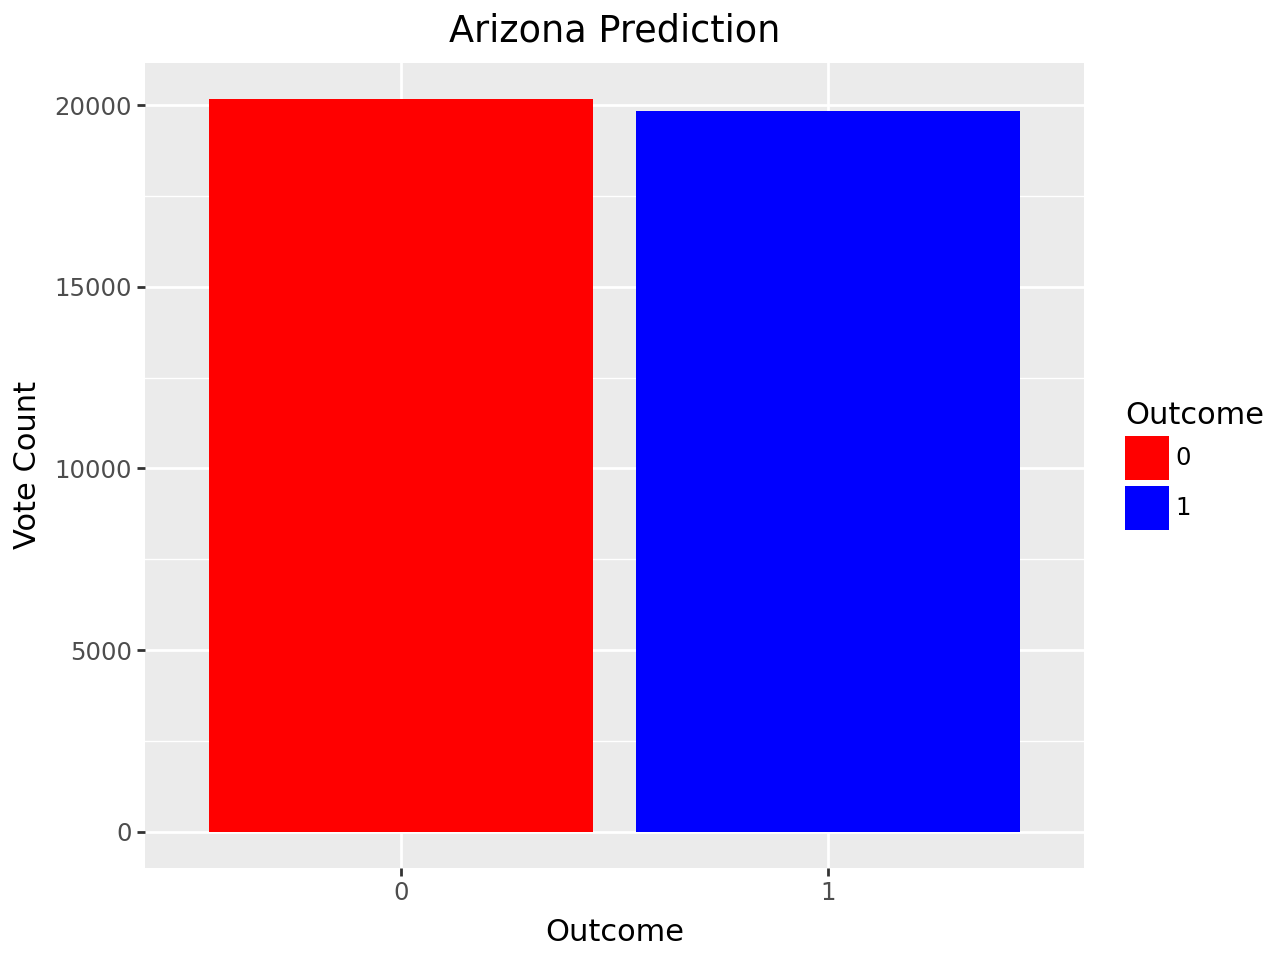

In [10]:
monte("Arizona")

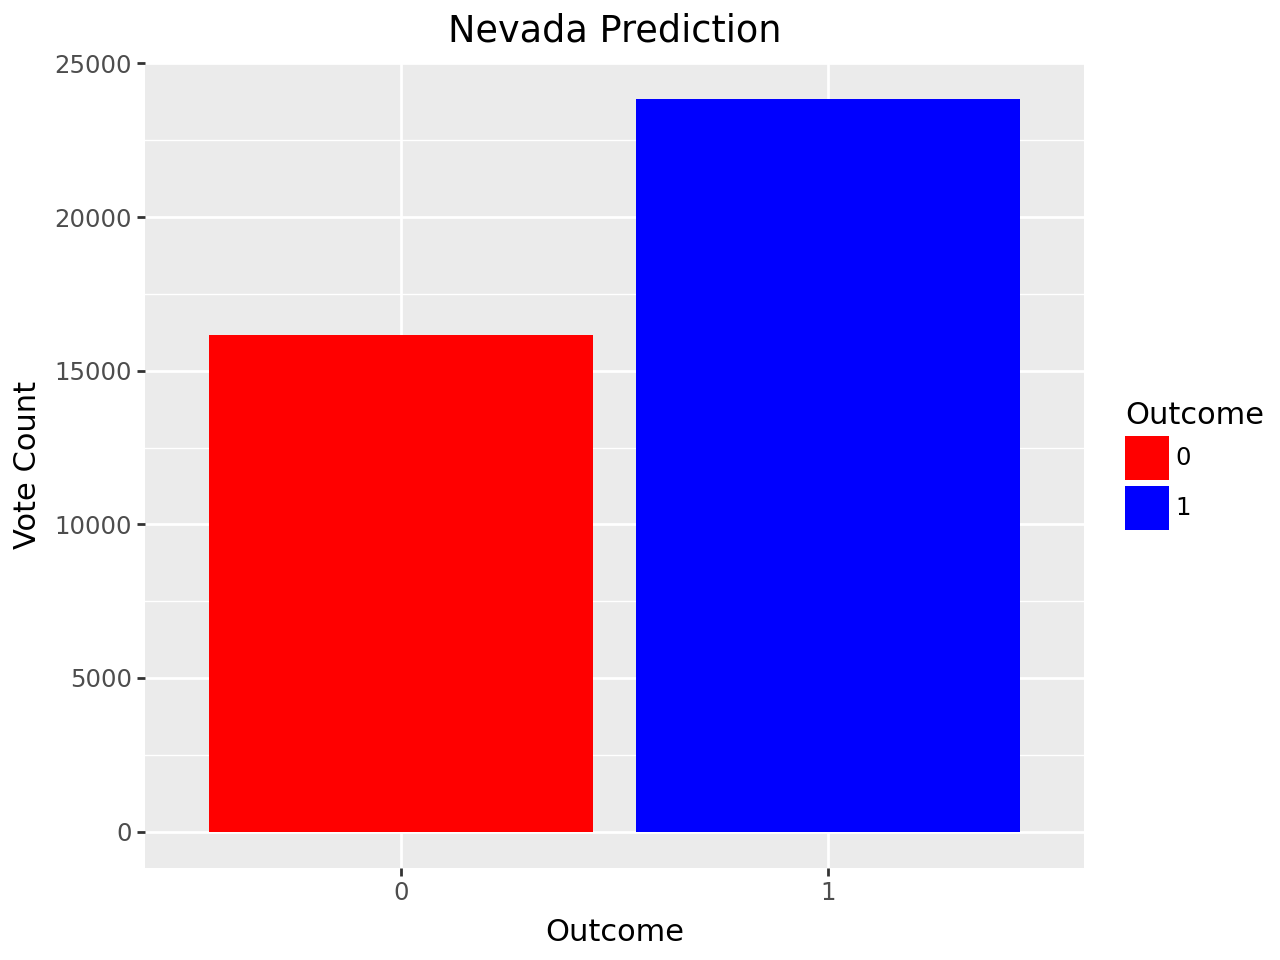

In [11]:
monte("Nevada")

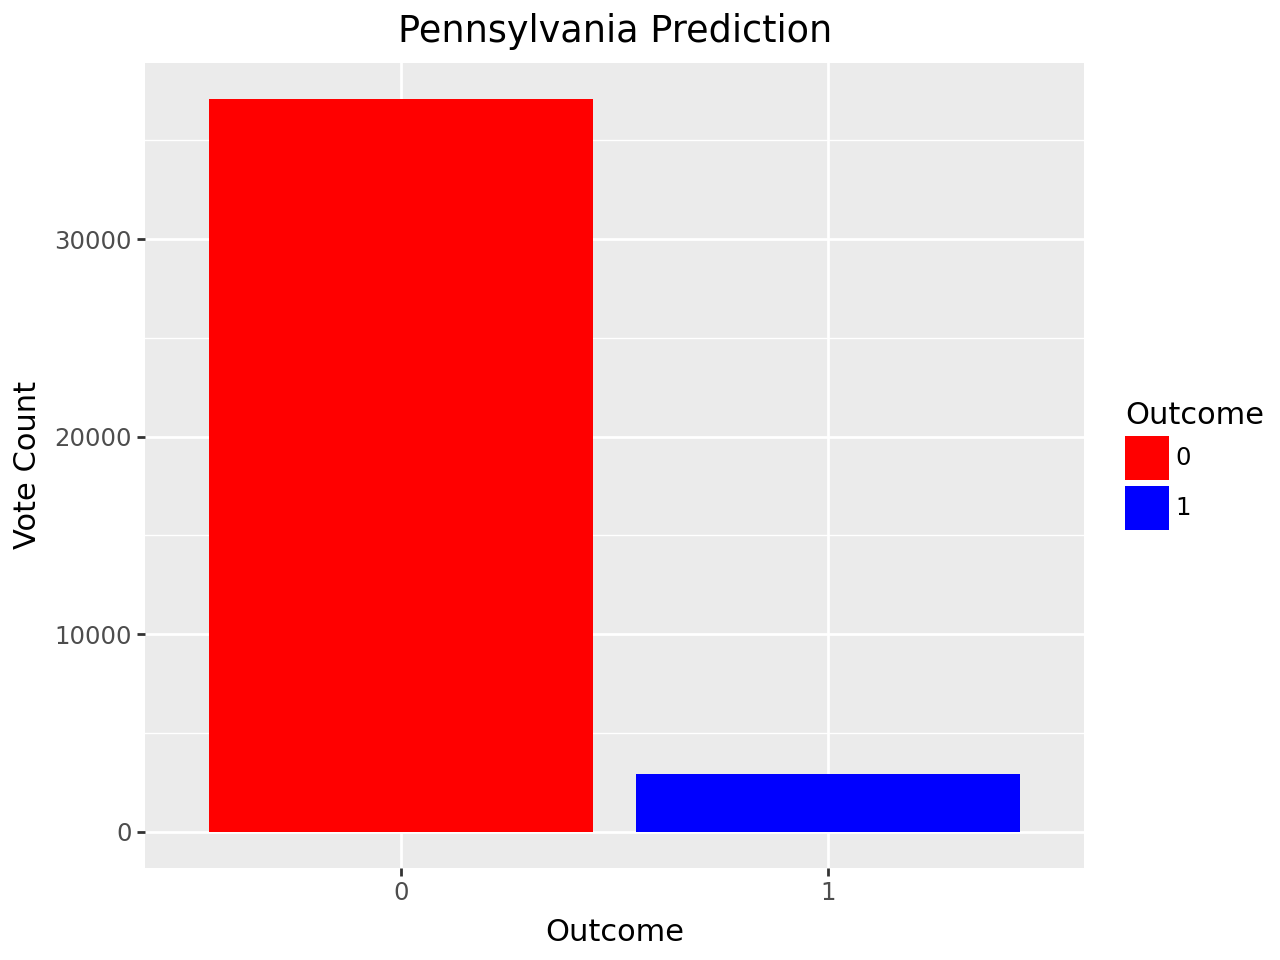

In [12]:
monte("Pennsylvania")

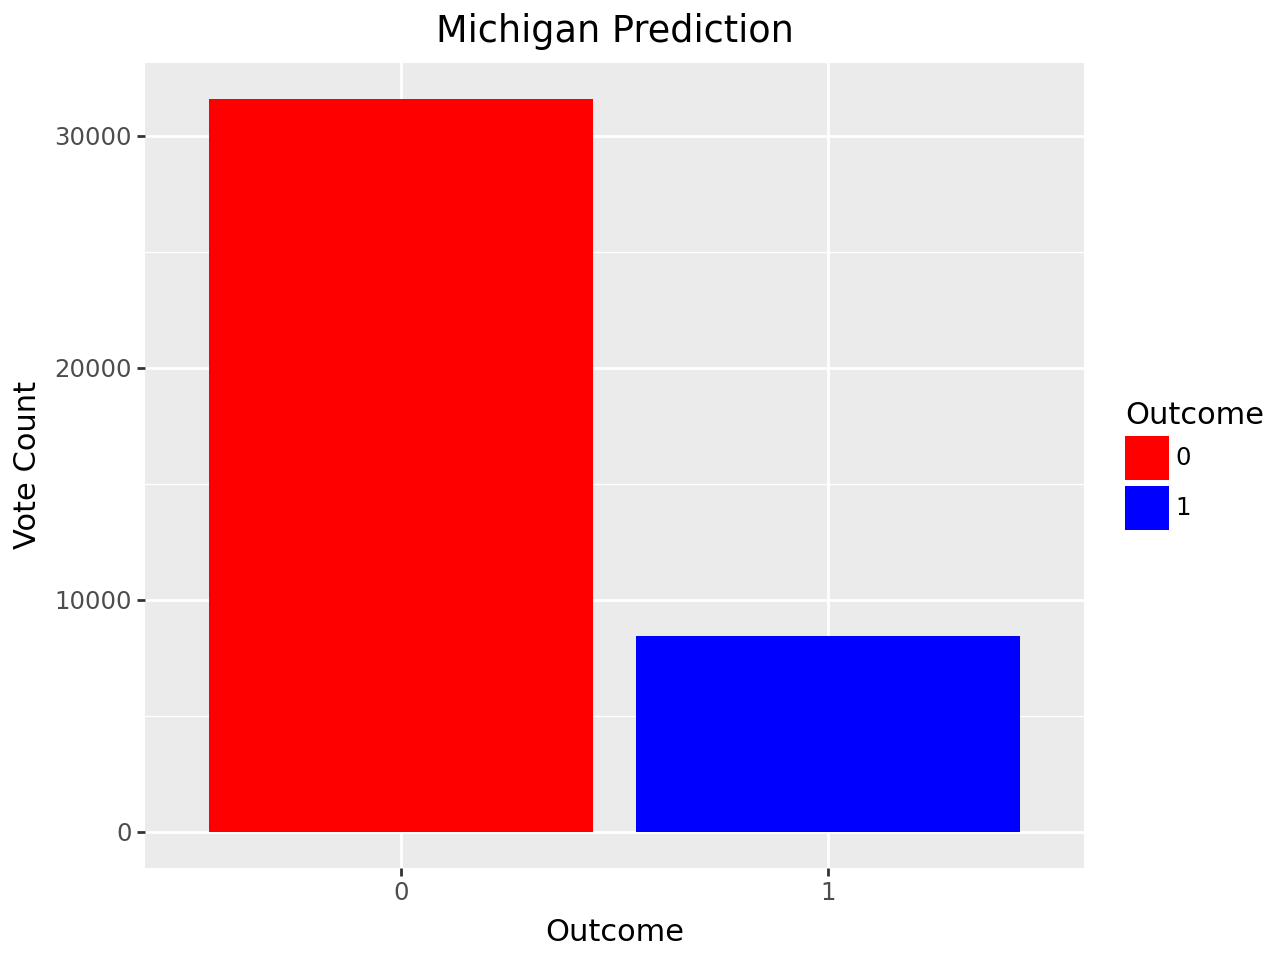

In [13]:
monte("Michigan")

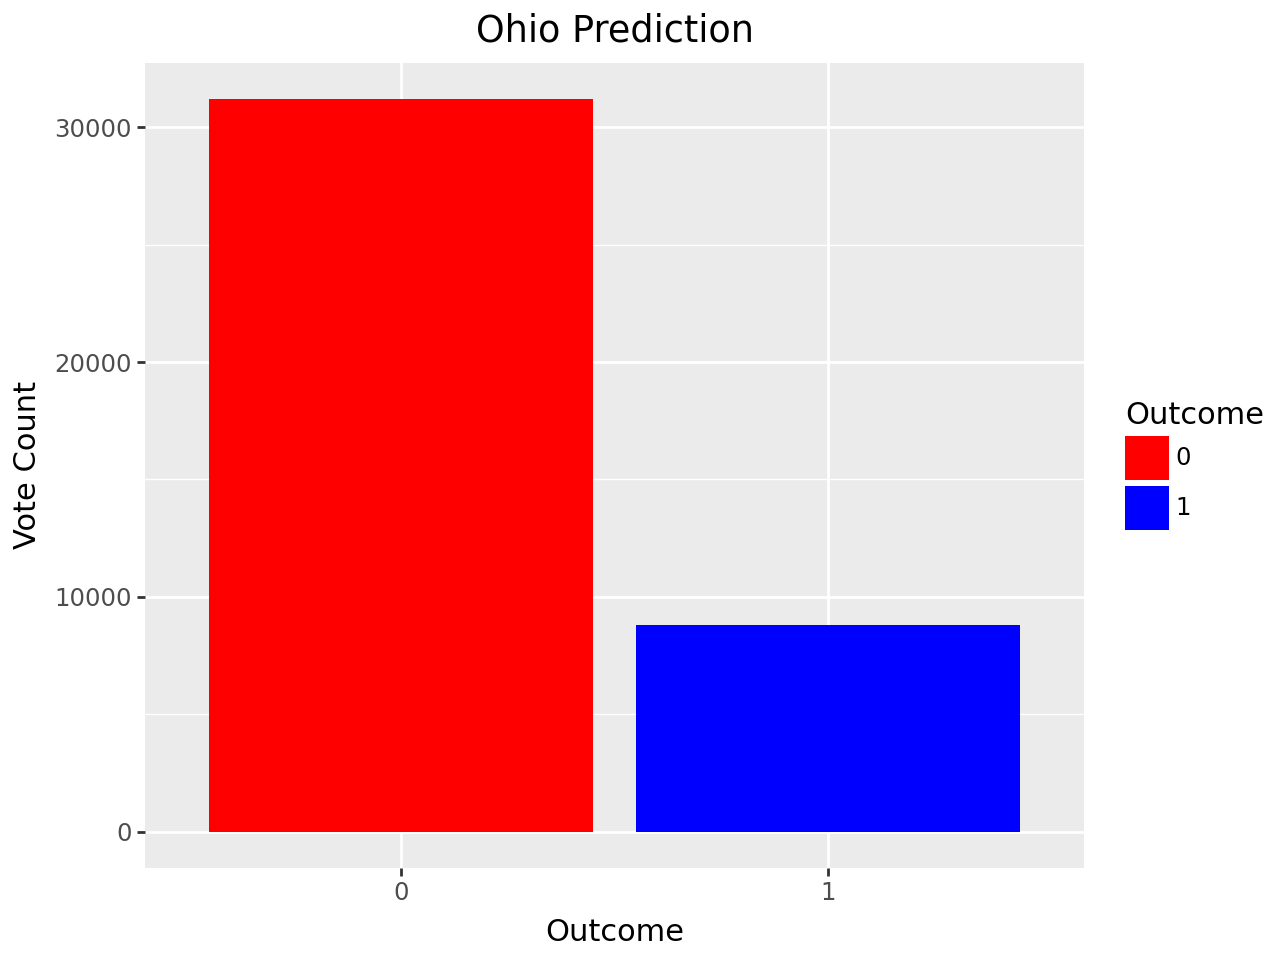

In [14]:
monte("Ohio")

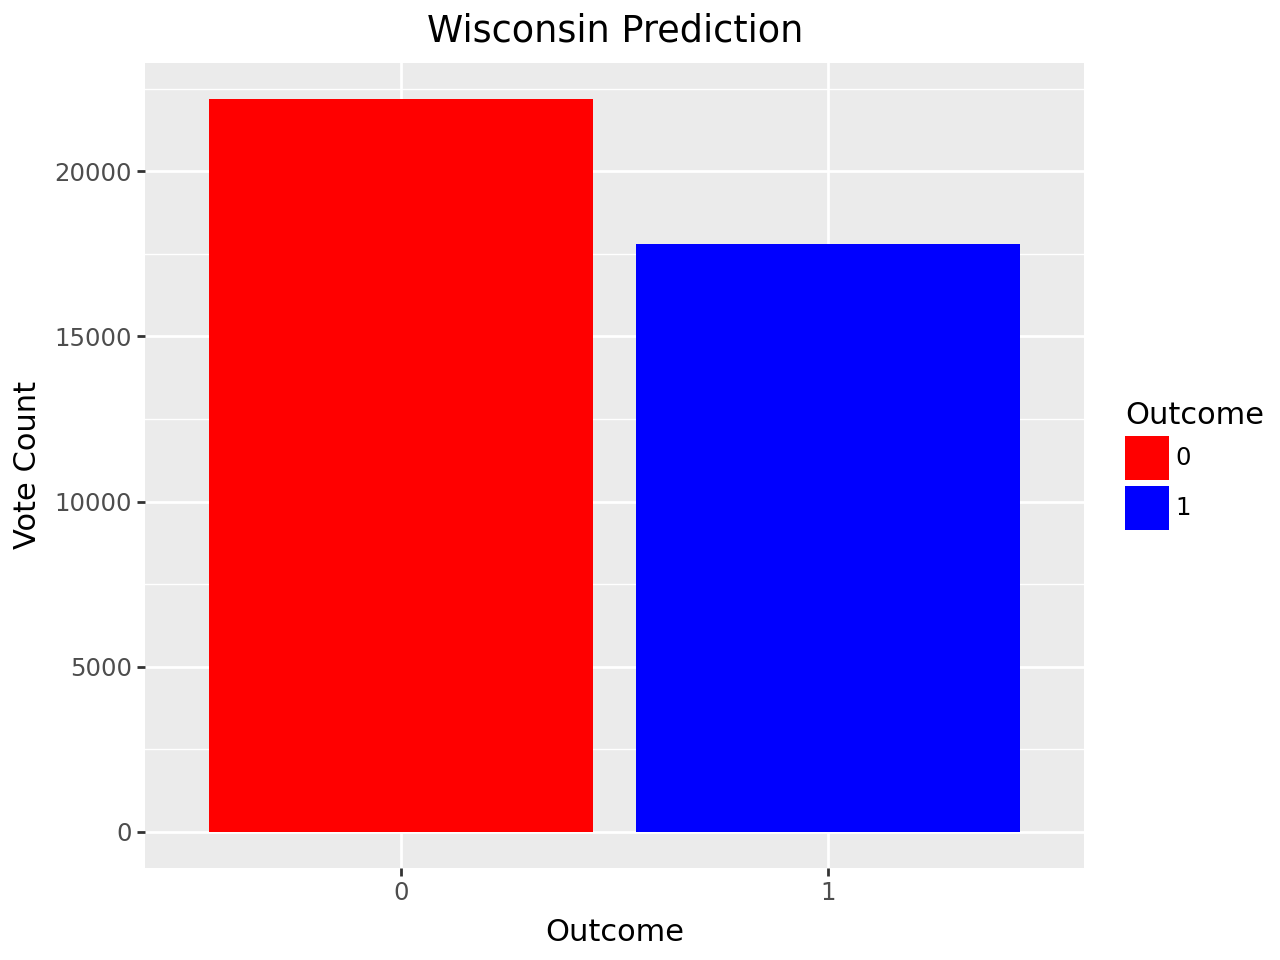

In [15]:
monte("Wisconsin")

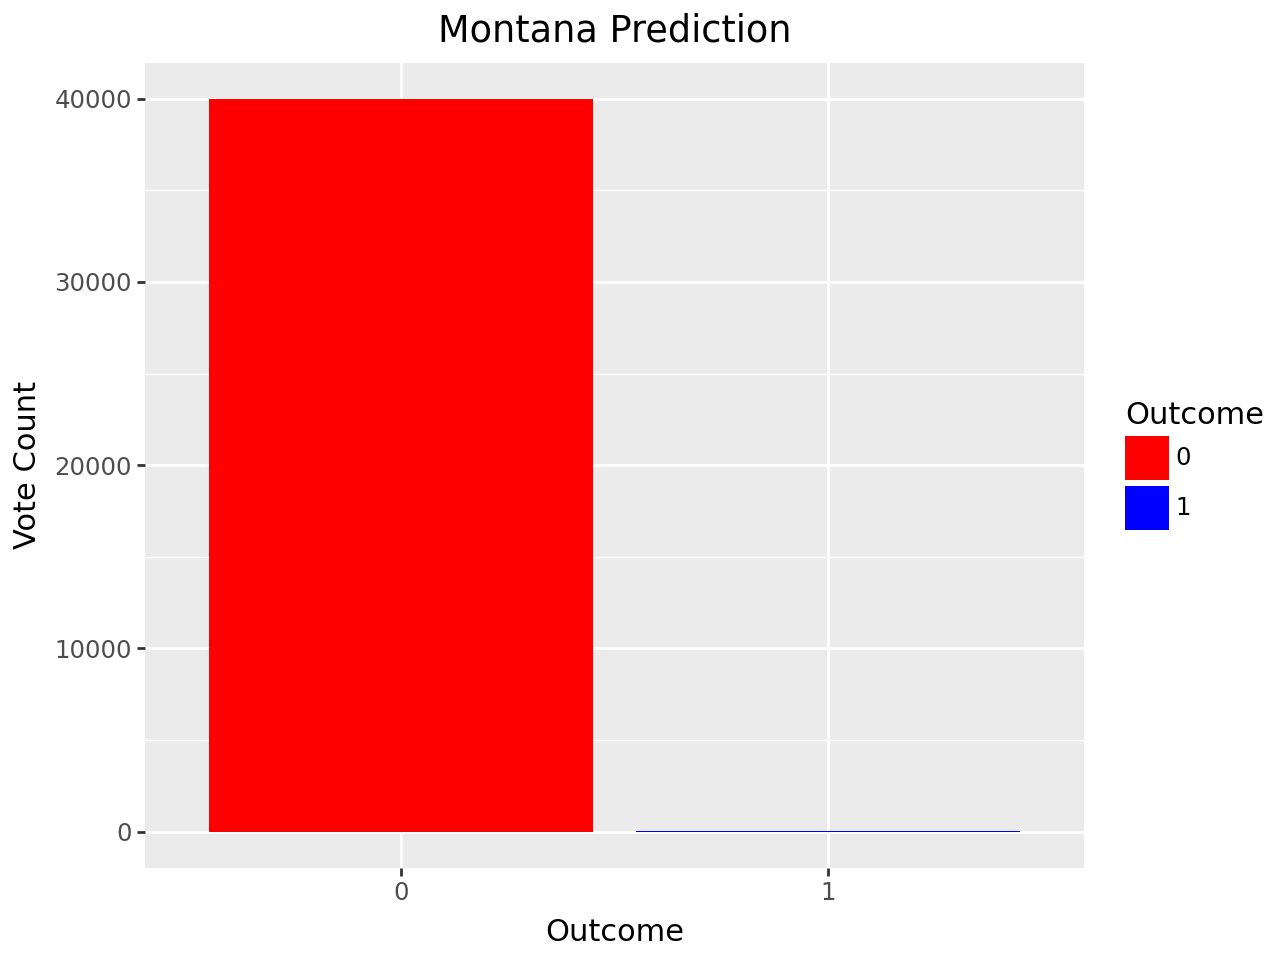

In [16]:
monte("Montana")

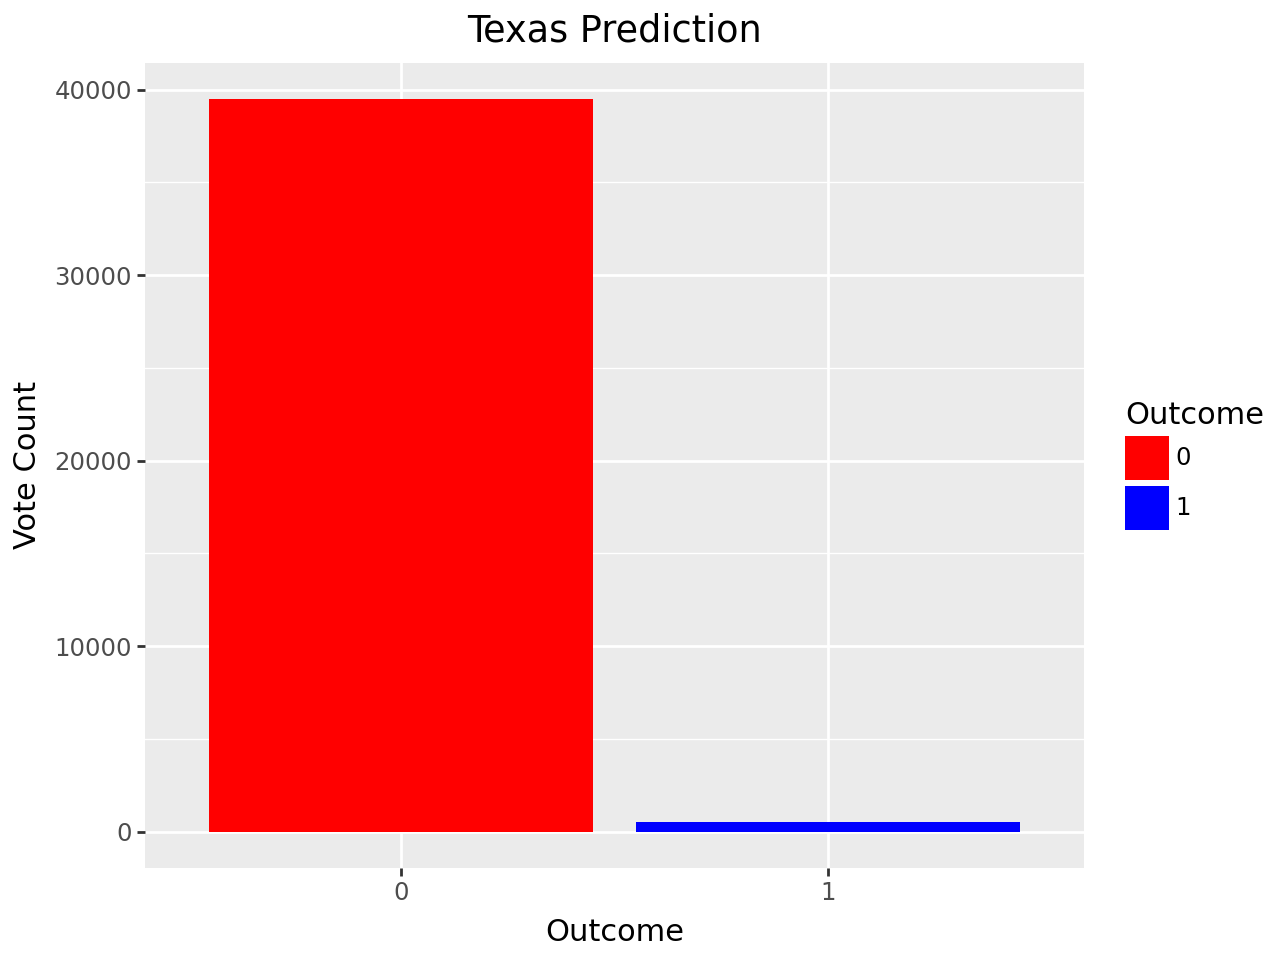

In [17]:
monte("Texas")

# Step 5: Conclusion

<u>**Overview**:</u>
The Monte Carlo simulations display that the midterm results for the key swing states will favor the Republican Party. Arizona is a toss up state and can go either way because it is predicted results fluctuate every time I run the simulation. It usually has around an even split between Democrats and Republicans, so it is extremely difficult to predict this outcome. Nevada is predicted to swing left and favor Democrats pretty heavily according to my simulation. Wisconsin favors the Republican party heavily by about 75%. The other five swing states (Pennsylvania, Michigan, Ohio, Texas, and Montana) are predicted to be dominated by the Republican Party. The simulations display that the Republicans will unproportionately win these swing states no matter how many times I ran them. 

<u>**Predicted States for Democrats to win**:</u>

Nevada (Jacky Rosen)

<u>**Predicted States for Republicans to win**:</u>

Pennsylvania(Dave McCormick)

Michigan(Mike Rogers)

Ohio(Bernie Moreno)

Montana(Tim Sheehy)

Texas(Ted Cruz)

<u>**Split Decision**:</u>

Arizona (Ruben Gallego (D) or Kari Lake (R))

<u>**Results**:</u>

Based off of the results of my Monte Carlo simulations, the Republican Party will take control of the Senate. The Republicans have control of the senate by having 53 seats compared to the Democrat's 46 (even if Arizona is won by the Democrats). My results partially match the Consensus Forecast, with the exception of Pennsylvania and Michigan. I had predicted that the Republican part would win these elections, but 270towin.com disagrees. These discrepancies can be attributed to the fact that I downloaded the data over a week ago, while the 270towin.com is a live statistical update of election predictions.